[*] Sensitivity matrix saved as 'sensitivity_matrix_heatmap.png'


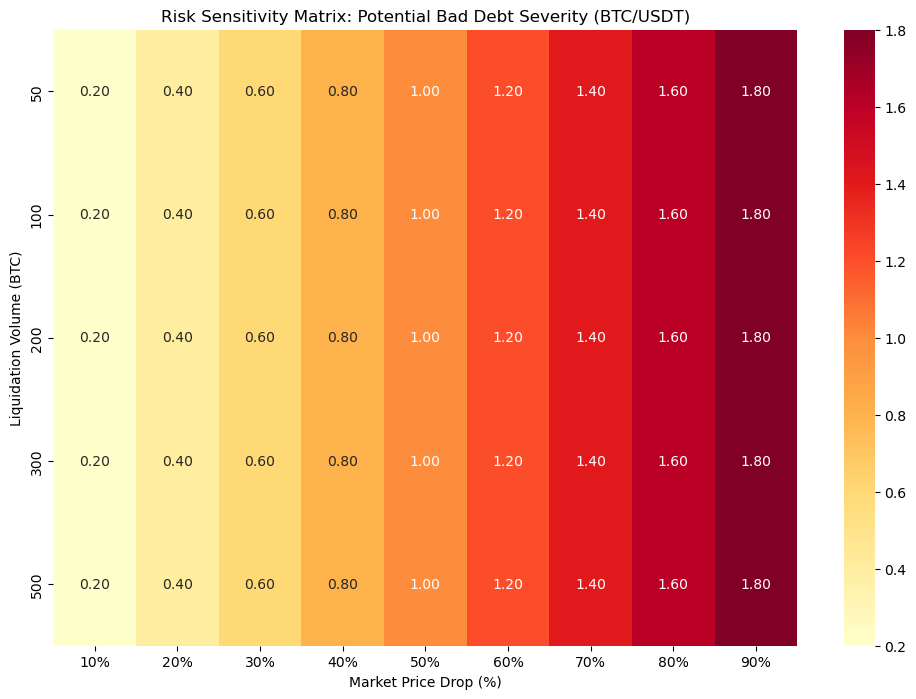

In [1]:
import ccxt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

class LiquidityDepthAnalyzer:
    def __init__(self, symbol='BTC/USDT'):
        self.exchange = ccxt.binance()
        self.symbol = symbol

    def fetch_l2_order_book(self):
        """Retrieves real-time Layer-2 (L2) Order Book data."""
        return self.exchange.fetch_order_book(self.symbol, limit=100)

    def get_slippage_for_size(self, order_book, notion_size_btc):
        """Calculates slippage for a specific liquidation size."""
        bids = order_book['bids']
        accumulated_volume = 0
        weighted_cost = 0
        mid_market_price = bids[0][0]
        
        for price, amount in bids:
            if accumulated_volume + amount >= notion_size_btc:
                remaining_fill = notion_size_btc - accumulated_volume
                weighted_cost += remaining_fill * price
                accumulated_volume += remaining_fill
                break
            else:
                accumulated_volume += amount
                weighted_cost += amount * price
        
        if accumulated_volume < notion_size_btc:
            return 1.0  # Liquidity exhausted
            
        execution_vwap = weighted_cost / notion_size_btc
        return (mid_market_price - execution_vwap) / mid_market_price

    def generate_insolvency_matrix(self):
        """
        NEW: Generates a Risk Sensitivity Matrix (Insolvency Matrix).
        Maps Price Drops vs. Available Liquidity to predict Bad Debt risk.
        """
        ob = self.fetch_l2_order_book()
        
        # Scenarios: Price Drop from 10% to 90%
        price_drops = np.arange(0.1, 1.0, 0.1)
        # Scenarios: Market Depth from 50 BTC to 500 BTC
        liquidity_scenarios = [50, 100, 200, 300, 500]
        
        matrix_data = []
        for liq in liquidity_scenarios:
            row = []
            slippage = self.get_slippage_for_size(ob, liq)
            for drop in price_drops:
                # Formula: Potential Bad Debt Severity = (Price Drop + Slippage Impact)
                # This models how a crash is worsened by thin order books.
                risk_score = drop * (1 + slippage)
                row.append(risk_score)
            matrix_data.append(row)
            
        df = pd.DataFrame(matrix_data, index=liquidity_scenarios, columns=[f"{int(d*100)}%" for d in price_drops])
        
        # Visualization: Heatmap
        plt.figure(figsize=(12, 8))
        sns.heatmap(df, annot=True, fmt=".2f", cmap="YlOrRd")
        plt.title(f"Risk Sensitivity Matrix: Potential Bad Debt Severity ({self.symbol})")
        plt.ylabel("Liquidation Volume (BTC)")
        plt.xlabel("Market Price Drop (%)")
        plt.savefig('sensitivity_matrix_heatmap.png')
        print("[*] Sensitivity matrix saved as 'sensitivity_matrix_heatmap.png'")
        return df

if __name__ == "__main__":
    analyzer = LiquidityDepthAnalyzer()
    matrix = analyzer.generate_insolvency_matrix()
    matrix.to_csv("sensitivity_matrix.csv")